In [4]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
rc('savefig', dpi = 300)
rc('figure', dpi = 100)


def format_plot(xlabel, ylabel, title, width=6, height=4, grid='on', despine=10):
    f = plt.gcf()
    f.set_size_inches(width,height)
    ax = plt.gca()
    sns.despine(offset=despine)
    plt.grid(grid)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, loc='left', fontweight='bold')
    
    leg = ax.get_legend()
    if leg is not None:
        leg.get_frame().set_linewidth(0.0)
        leg.get_frame().set_alpha(0.5)

    plt.tight_layout()

In [5]:
from typing import Callable, Tuple

from numpy import ndarray


class Indices:
    def __init__(self, name: str, get_new_index: Callable[[float, int], float]) -> None:
        self.indices = []
        self.get_new_index = get_new_index
        self.name = name

    def add(self):
        N = len(self.indices)
        if N == 0:
            max_index = 0
        else:
          max_index = self.indices[-1]

        new_index = self.get_new_index(max_index, len(self.indices))
        self.indices.append(new_index)

    def remove(self, pos: int):
        if len(self.indices) == 0:
            return
        self.indices.pop(pos)

    def move_back(self, pos: int):
        if pos <= 0:
            return
        if pos == 1:
            prevprev = 0
        else:
          prevprev = self.indices[pos - 2]
        prev = self.indices[pos - 1]
        new_index = 0.5 * (prev + prevprev)
        self.indices[pos] = new_index
        self.indices.sort()

    def move_forward(self, pos: int):
        N = len(self.indices)

        if pos >= N - 1:
            return
        if pos == N - 2:
            nextnext = 1
        else:
            nextnext = self.indices[pos + 2]
        next = self.indices[pos + 1]
        new_index = 0.5 * (next + nextnext)
        self.indices[pos] = new_index
        self.indices.sort()

    def move_to_back(self, pos: int):
        if len(self.indices) == 0:
            return
        new_index = 0.5 * self.indices[0]
        self.indices[pos] = new_index
        self.indices.sort()

    def move_to_front(self, pos: int):
        if len(self.indices) == 0:
            return
        new_index = 0.5 * (1 + self.indices[-1])
        self.indices[pos] = new_index
        self.indices.sort()

    def populate(self, N: int):
        for i in range(N):
            self.add()

    def get_cdf(self) -> Tuple[ndarray, ndarray]:
        counts, edges = np.histogram(self.indices, bins=np.linspace(0, 1, 101))
        cdf = np.cumsum(counts) / len(self.indices) # Counts at top of bins
        cdf_with_zero = np.insert(cdf, 0, 0)
        return edges, cdf_with_zero
    
    def get_score(self):
        x, y = self.get_cdf()
        area = np.sum(np.abs(y - x))
        return area

    def plot(self):
        plt.plot(*self.get_cdf(), label='Current')
        plt.plot([0, 1], [0, 1], '--', label='Even', c='black', alpha=0.3)
        plt.legend()

        format_plot('z-index', 'CDF', self.name)

        plt.show()


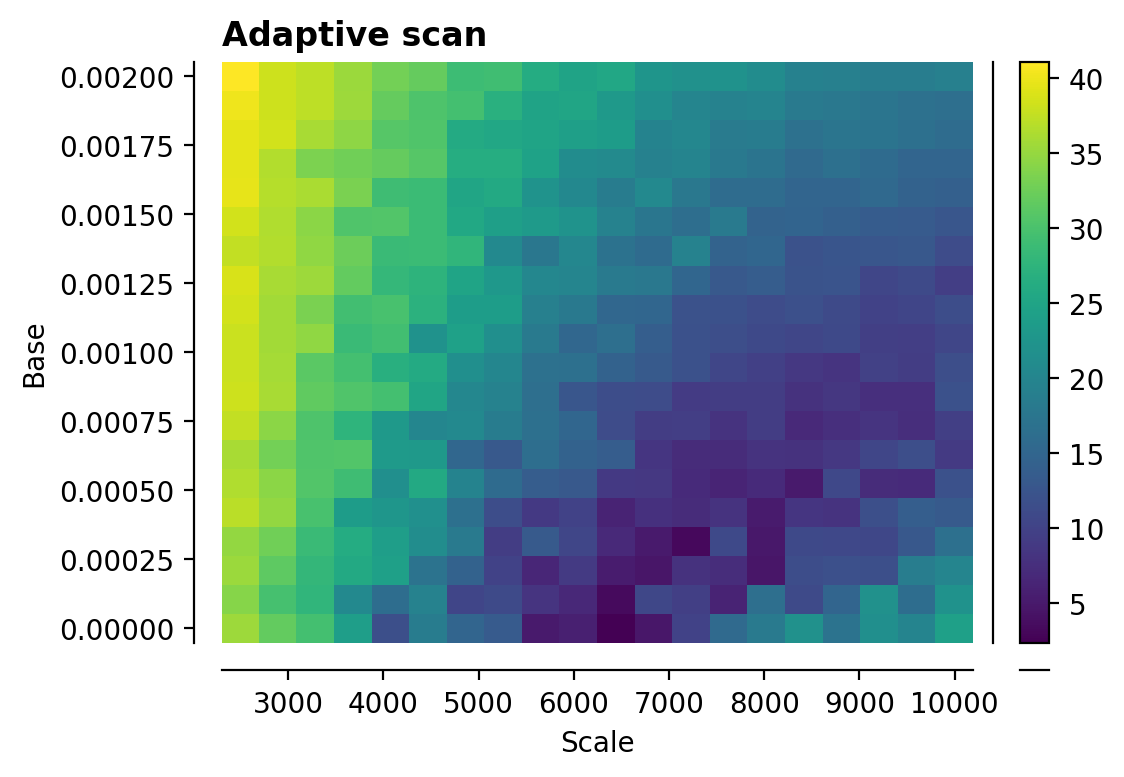

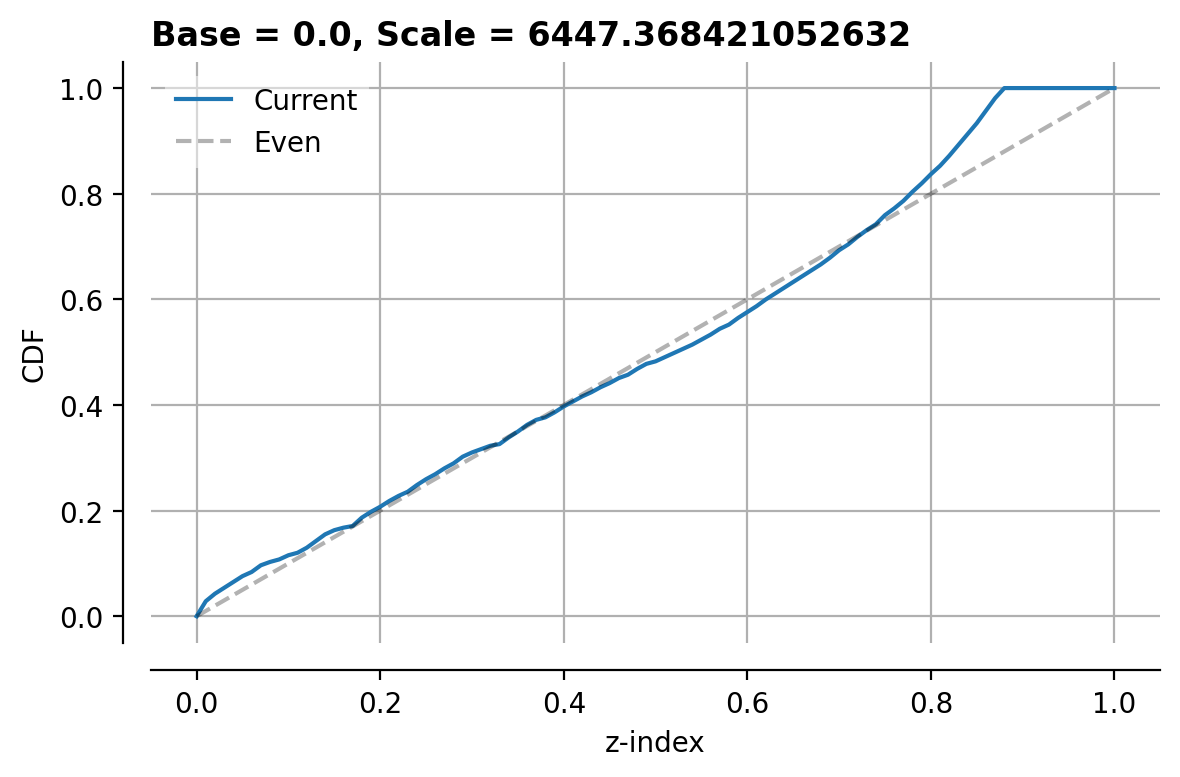

In [51]:
def get_new_index_1(max_index: float, N: int) -> float:
    return 0.5 * (1 + max_index)

def get_weighted(weight: float):
    def get_new_index(max_index: float, N: int) -> float:
        return 0.5 * (weight + (2 - weight) * max_index)
    
    return get_new_index

def get_adaptive(base: float, scale: float) -> float:
    def get_new_index(max_index: float, N: int) -> float:
        fac1 = base + (N/scale)**2
        fac2 = 2 - fac1
        return 0.5 * (fac1 + fac2 * max_index)
    return get_new_index

def run_sim(indices: Indices):
    Nmoves = 2000

    for i in range(Nmoves):
        N = len(indices.indices)
        pos = int(np.floor(N * np.random.uniform()))
        r1 = np.random.uniform() # Add/remove, or change order
        r2 = np.random.uniform() # Which action to take

        if r1 < 1.995 or N == 0:

            if r2 < 0.65:
                indices.add()
            else:
                indices.remove(pos)
        else:

            if r2 < 0.28:
                indices.move_to_back(pos)
            elif r2 < 0.55:
                indices.move_back(pos)
            elif r2 < 0.78:
                indices.move_to_front(pos)
            else:
                indices.move_forward(pos)

bases = np.linspace(0, 2e-3, 20)
scales = np.linspace(2.5e3, 10e3, 20)
scores = np.zeros((len(bases), len(scales)))

best_score = 100
best_inds = None

for i in range(len(bases)):
    for j in range(len(scales)):
        inds = Indices(f'Base = {bases[i]}, Scale = {scales[j]}', get_adaptive(bases[i], scales[j]))
        run_sim(inds)
        score = inds.get_score()
        scores[i, j] = score
        if score < best_score:
            best_score = score
            best_inds = inds

plt.pcolor(scales, bases, scores)
plt.colorbar()
format_plot('Scale', 'Base', 'Adaptive scan')
plt.grid(None)
plt.show()

best_inds.plot()
plt.show()


In [ ]:
N